# Deep Learning Based Automatic Malaria Parasite Detection

In [12]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [13]:
data_dir = 'cell_images/'
train_path = data_dir + 'train/'
test_path = data_dir + 'test/'

In [14]:
os.listdir(data_dir)

['.DS_Store', 'test', 'train']

In [21]:
os.listdir(train_path)

['.DS_Store', 'parasitized', 'uninfected']

In [24]:
print(len(os.listdir(train_path+'parasitized')))
print(len(os.listdir(train_path+'uninfected')))

12480
12480


In [25]:
print(len(os.listdir(test_path+'parasitized')))
print(len(os.listdir(test_path+'uninfected')))

1300
1300


The parasitized and uninfected group are balanced in train and test.

## Infected vs Uninfected

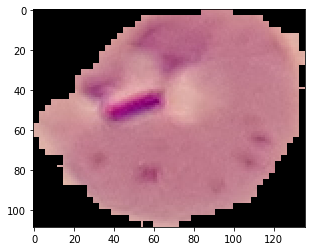

In [18]:
infected_cell = train_path + 'parasitized/'+os.listdir(train_path+'parasitized')[21]
plt.imshow(imread(infected_cell))

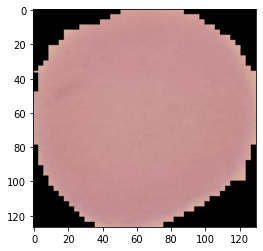

In [19]:
uninfected_cell = train_path + 'uninfected/'+os.listdir(train_path+'uninfected')[21]
plt.imshow(imread(uninfected_cell))

In [20]:
imread(uninfected_cell).shape

(127, 130, 3)

## Average Dimensions of the Images

In [30]:
dim1 = []
dim2 = []
for img_name in os.listdir(train_path+'uninfected'):
    img = imread(train_path+'uninfected/'+img_name)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

In [34]:
np.mean(dim1)

131.64820899110507

In [35]:
np.mean(dim2)

131.4041990544114

/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


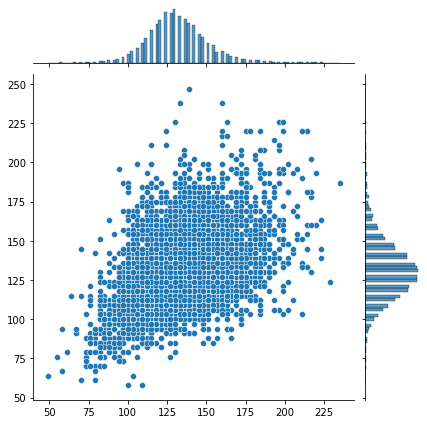

In [36]:
sns.jointplot(dim1,dim2)

In [43]:
image_shape = (131,131,3)

## Data Processing

### Generating Many Manipulated Images

In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [44]:
image_gen = ImageDataGenerator(rotation_range = 20,
                              width_shift_range = 0.1,
                              height_shift_range = 0.1,
                            ##rescale = 1/255 The images are already scaled.
                               shear_range = 0.1,
                               zoom_range = 0.1,
                               horizontal_flip = True,
                               fill_mode = 'nearest'
                              )

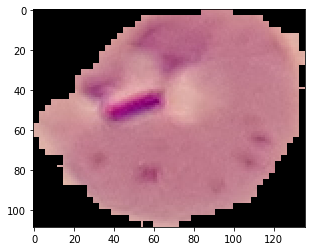

In [45]:
plt.imshow(imread(infected_cell))

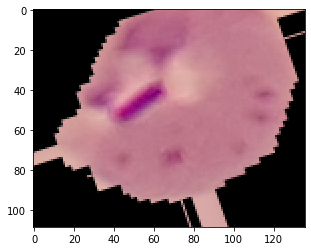

In [46]:
plt.imshow(image_gen.random_transform(imread(infected_cell)))

In [49]:
batch_size = 16

In [50]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 24958 images belonging to 2 classes.


In [51]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',
                                               shuffle=False)

Found 2600 images belonging to 2 classes.


In [52]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

## Training the model

### Early Stopping

In [53]:
from tensorflow.keras.callbacks import EarlyStopping

In [69]:
early_stopping = EarlyStopping(monitor='val_loss',patience=2)

### Creating the model

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [56]:
model = Sequential()

In [58]:
model.add(Conv2D(filters = 32, kernel_size = (3,3),input_shape = image_shape, activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

In [59]:
model.add(Conv2D(filters = 64, kernel_size = (3,3),input_shape = image_shape, activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

In [60]:
model.add(Conv2D(filters = 64, kernel_size = (3,3),input_shape = image_shape, activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

In [61]:
model.add(Flatten())

In [63]:
model.add(Dense(units = 128, activation = 'relu'))

In [64]:
model.add(Dropout(0.5))

In [66]:
# Output Layer
model.add(Dense(1,activation = 'sigmoid'))

In [67]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [68]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 129, 129, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [71]:
results = model.fit_generator(train_image_gen, 
                              epochs = 20, 
                              validation_data = test_image_gen,
                              callbacks = early_stopping)

/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
1560/1560 [==============================] - 247s 158ms/step - loss: 0.9975 - accuracy: 0.5540 - val_loss: 0.6845 - val_accuracy: 0.5608
Epoch 2/20
1560/1560 [==============================] - 233s 149ms/step - loss: 0.6761 - accuracy: 0.5890 - val_loss: 0.6684 - val_accuracy: 0.6142
Epoch 3/20
1560/1560 [==============================] - 242s 155ms/step - loss: 0.6262 - accuracy: 0.6369 - val_loss: 0.3859 - val_accuracy: 0.8754
Epoch 4/20
1560/1560 [==============================] - 257s 165ms/step - loss: 0.2471 - accuracy: 0.9236 - val_loss: 0.2266 - val_accuracy: 0.9273
Epoch 5/20
1560/1560 [==============================] - 262s 168ms/step - loss: 0.1947 - accuracy: 0.9394 - val_loss: 0.1822 - val_accuracy: 0.9412
Epoch 6/20
1560/1560 [==============================] - 263s 169ms/step - loss: 0.1847 - accuracy: 0.9433 - val_loss: 0.1930 - val_accuracy: 0.9431
Epoch 7/20
1560/1560 [==============================] - 258s 166ms/step - loss: 0.1755 - accuracy: 0.9461 - val_

In [72]:
from tensorflow.keras.models import load_model
model.save('malaria_detector_model.h5')

## Evaluating the model

In [74]:
losses = pd.DataFrame(model.history.history)
losses

,loss,accuracy,val_loss,val_accuracy
0,0.997510,0.553971,0.684548,0.560769
1,0.676053,0.588989,0.668361,0.614231
2,0.626198,0.636910,0.385911,0.875385
3,0.247123,0.923632,0.226614,0.927308
4,0.194712,0.939378,0.182200,0.941154
5,0.184720,0.943265,0.192963,0.943077
6,0.175511,0.946069,0.177115,0.934231
7,0.175707,0.944146,0.178566,0.938077
8,0.171313,0.947632,0.162230,0.944231
9,0.171095,0.946911,0.186106,0.943462


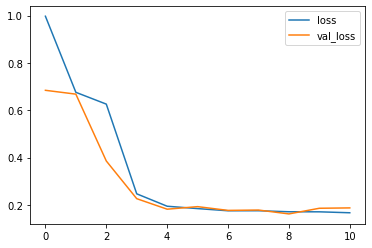

In [79]:
losses[['loss','val_loss']].plot()

In [81]:
model.metrics_names

['loss', 'accuracy']

In [82]:
model.evaluate_generator(test_image_gen)

/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.17277535796165466, 0.9457692503929138]

In [83]:
from tensorflow.keras.preprocessing import image

In [84]:
pred_probabilities = model.predict_generator(test_image_gen)

/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [85]:
pred_probabilities

array([[2.9816182e-08],
       [8.0180695e-07],
       [1.8457545e-08],
       ...,
       [9.6682918e-01],
       [9.8247224e-01],
       [9.6128809e-01]], dtype=float32)

In [88]:
predictions = pred_probabilities > 0.5
predictions

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [89]:
from sklearn.metrics import classification_report,confusion_matrix

In [91]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [90]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1300
           1       0.94      0.94      0.94      1300

    accuracy                           0.94      2600
   macro avg       0.94      0.94      0.94      2600
weighted avg       0.94      0.94      0.94      2600



In [92]:
confusion_matrix(test_image_gen.classes,predictions)

array([[1227,   73],
       [  73, 1227]])